<a href="https://colab.research.google.com/github/lakshayj11/Stock-Prediction-Using-Q-Learning/blob/main/Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Stock Price using Deep Q-Networks

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from collections import deque
import random

## Importing Data

In [ ]:
powergrid = pd.read_csv('POWERGRID.csv')
maruti = pd.read_csv('MARUTI.csv')
bajajfinsv = pd.read_csv('BAJAJFINSV.csv')

powergrid.name = 'Powergrid'
maruti.name = 'Maruti'
bajajfinsv.name = 'Bajaj Finserv'

stocks = [powergrid, maruti, bajajfinsv]

## Visualizing Data

In [ ]:
for stock in stocks:
    
    stock['Date'] = pd.to_datetime(stock.Date,format='%Y-%m-%d')
#     f = plt.figure()
#     f.set_figwidth(20)
#     f.set_figheight(10)

#     plt.scatter(stock['Date'], stock['Adj Close']) # To visualize individual points
#     plt.plot(stock['Date'], stock['Adj Close'])
    
#     plt.title(stock.name)
#     plt.ylabel('Stock Closing Price')
#     plt.xlabel('Date')
#     plt.show()

## Feature Selection

In [ ]:
scaler = MinMaxScaler()
for stock in stocks:
    
    stock[['Open_Scaled', 'High_Scaled', 'Low_Scaled', 'Close_Scaled', 'Volume_Scaled', 'Adj_Close_Scaled']] = scaler.fit_transform(
        stock[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']])
    
    stock['7MA'] = stock.iloc[:, 12].rolling(window=7).mean()
    stock['14MA'] = stock.iloc[:, 12].rolling(window=14).mean()
    stock['21MA'] = stock.iloc[:, 12].rolling(window=21).mean()
    stock['7SD'] = stock.iloc[:, 12].rolling(window=7).std()

    stock.dropna(inplace=True)

features = ['Open_Scaled', 'High_Scaled', 'Low_Scaled', 'Close_Scaled','Adj_Close_Scaled', 'Adj Close', 'Volume_Scaled', '7MA', '14MA', '21MA', '7SD']

predict = 'Adj Close'



## Test-Train Split

In [ ]:
train_powergrid = powergrid[:2223]
test_powergrid = powergrid[2223:]
test_powergrid.name = powergrid.name

train_maruti = maruti[:2223]
test_maruti = maruti[2223:]
test_maruti.name = maruti.name

train_bajajfinsv = bajajfinsv[:2223]
test_bajajfinsv = bajajfinsv[2223:]
test_bajajfinsv.name = bajajfinsv.name

train_test = [[train_powergrid, test_powergrid], [train_maruti, test_maruti], [train_bajajfinsv, test_bajajfinsv]]

## Fixing Hyperparameters

In [ ]:
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01

DISCOUNT = 0.95

LEARNING_RATE = 0.03
REPLAY_SIZE = 5000
BATCH_SIZE = 16

MAX_TRANSACTIONS = 20
INITIAL_CAPITAL = 10_00_000

MIN_SIZE = 250
TARGET_UPDATE_THRESHOLD = 100

## Creating model

In [ ]:
class TradingAgent:
    
    def __init__(self, epsilon = 1, learning_rate = 0.01, epsilon_min = 0.01, epsilon_decline = 0.98, discount = 0.95,
                 batch_size = 64, replay_size = 500, money = 10_00_000, max_transactions = 10,
                target_update_threshold = 32, min_size = 500):
        
        # Create Replay Memory
        self.replay = deque(maxlen = replay_size)
        
        # Exploration
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decline = epsilon_decline
        
        self.state_size = len(features) + 2
        self.action_space = 3
        self.learning_rate = learning_rate
        self.discount = discount
        self.batch_size = batch_size
        self.min_size = min_size
        
        # Money and Transaction 
        self.inventory = []
        self.money = money
        self.max_transactions = max_transactions
        
        # Main Network
        self.model = self.create_model()
        
        # Target Network
        self.target = self.create_model()
        self.target.set_weights(self.model.get_weights())
        
        # Update Target Network Weights
        self.target_update = 0
        self.target_update_threshold = target_update_threshold
        
    def create_model(self):
        
        
        model = keras.Sequential()
        
        model.add(layers.Dense(8, activation='relu', input_shape=(1, self.state_size))),
        # model.add(layers.Dense(16, activation='relu')),
        # model.add(layers.Dense(8, activation='relu')),
        model.add(layers.Dense(3, activation='linear'))
        
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        
        model.build(input_shape=(1, self.state_size))
        
        return model
    
    
    # Transition = (State, Action, Reward, New State)
    def update_replay_memory(self, transition):
        self.replay.append(transition)
    
    
    
    def action(self, state):
        if (random.random() < self.epsilon):
            return random.randrange(0, self.action_space)
        else:
            return np.argmax(self.model.predict(state))
    
    
    
    
    # Current_state = (Open_Scaled, High_Scaled, Low_Scaled, Close_Scaled, Adj_Close_Scaled, Adj Close, Volume,
    # Moving Average 7, Moving Average 14, Moving Average 21, Standard Deviation 7, Number of stock batches, Money)
    def buy(self, state):
        
        if (state[-1] > state[5]):      # Buy if you have money
            Num_stocks = min(self.max_transactions, int(state[-1]/state[5]))
            self.money -= Num_stocks * state[5]
            self.inventory.append([Num_stocks, state[5]])
            
            return 5                    # Used money to buy stocks
        
        else:
            return -1                   # Trying to buy without money
        
        if (state[-2] > 0):
            reward = 0
            for quantity, cost in self.inventory:
                reward += quantity

            if (reward > self.max_transactions * 10):     #If already have a lot of stocks
                return -1
        
        return -1                       # Don't have money and haven't bought stocks
    
    # Sell all the stocks and get reward = profit/loss
    def sell(self, state):
        if (state[-2] == 0):    # I have no stocks and still try to sell
            return -10
            
        reward = 0
        
        for quantity, cost in self.inventory:
            reward += quantity * (state[5] - cost)        # Profit/loss
            self.money += quantity * (state[5])           # Money gained from selling
        
        self.inventory.clear()                            # Clear stock inventory
        return reward

    
    
    # Do nothing to stocks
    def hold(self, state):
        if (state[-2] == 0 and (state[4] > (state[9] + state[8]) / 2)):    # Might have been a good buying/selling opportunity
            return -1
        
        else:
            return 0
    
    
    
    
    # Train the network on replay memory
    def train(self):
        
        if (len(self.replay) < self.min_size):  # If the replay memory size is less than minimum permissible value then return
            return
        
        minibatch = random.sample(self.replay, self.batch_size)
        
        current_states = np.array([transistion[0] for transistion in minibatch])
        current_q_list = self.model.predict(current_states)
        
        new_states = np.array([transistion[3] for transistion in minibatch])
        future_q_list = self.target.predict(new_states)
        
        X = []
        Y = []
        
        for index, (current_state, action, reward, new_state) in enumerate(minibatch):
            
            max_future_q = np.max(future_q_list[index])
            new_q = reward + self.discount * max_future_q
            
            current_q = current_q_list[index]
            current_q[action] = new_q
            
            X.append(current_state)
            Y.append(current_q)
        
        self.model.fit(np.array(X), np.array(Y), batch_size = self.batch_size, verbose=False)
            
        self.target_update += 1
        
        # Update Target Network Weights
        if (self.target_update > self.target_update_threshold):
            self.target.set_weights(self.model.get_weights())
            self.target_update = 0


## Training the agent

In [ ]:
agent = TradingAgent(epsilon = EPSILON, learning_rate = LEARNING_RATE, epsilon_min = EPSILON_MIN, epsilon_decline = EPSILON_DECAY, discount = DISCOUNT,
                 batch_size = BATCH_SIZE, replay_size = REPLAY_SIZE, money = INITIAL_CAPITAL, max_transactions = MAX_TRANSACTIONS,
                target_update_threshold = TARGET_UPDATE_THRESHOLD, min_size = MIN_SIZE)


EPISODES = 15
CLEAR_EVERY = 2

states = np.array(train_bajajfinsv[features])
prices = np.array(train_bajajfinsv[predict])

code = {0:'b', 1:'g', 2:'r'}
action_list = []


for episode in range(0, EPISODES):
    
    
    if (episode % CLEAR_EVERY == 0):
      agent.replay.clear()

    agent.target.set_weights(agent.model.get_weights())
    agent.epsilon = EPSILON
    
    for idx in range(0, len(states)-1):
        
        curr_state = np.append(states[idx], [len(agent.inventory), agent.money])
        
        #Select a greedy or random action
        action = agent.action(curr_state.reshape(-1, agent.state_size))          
        
        # Perform action
        
        if (action == 0):
            reward = agent.buy(curr_state)
        elif (action == 1):
            reward = agent.sell(curr_state)
        else:
            reward = agent.hold(curr_state)
        
        action_list.append(action)
        
        if (agent.epsilon < agent.epsilon_min):
            agent.epsilon = agent.epsilon_min
        else:
            agent.epsilon *= agent.epsilon_decline
        # Add that (state, action, reward, new_state) tuple to replay memory
        
        new_state = np.append(states[idx+1], [len(agent.inventory), agent.money])
        agent.update_replay_memory((curr_state, action, reward, new_state))
        
        agent.train()
    
    plt.figure(figsize=(10,10))
    plt.title(episode)
    plt.scatter(maruti['Date'][:-1], prices[:-1], color = [code[i] for i in action_list])
    plt.show()
    
    action_list.clear()
    
        


KeyboardInterrupt: ignored

## Testing and Plotting the data

Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0
Profit % = 0.0


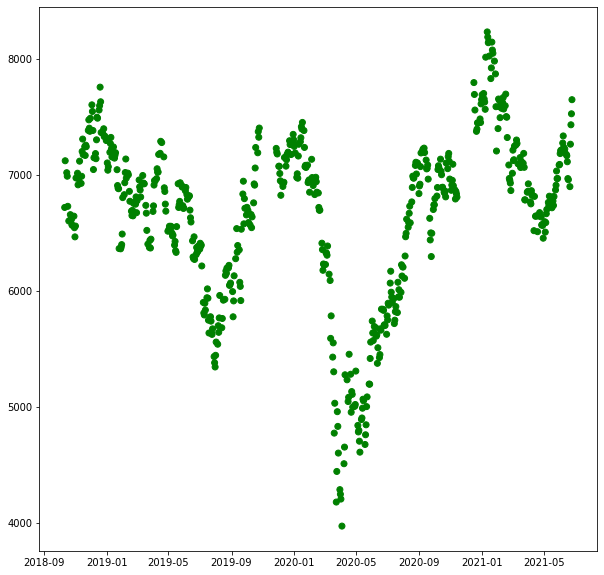

In [ ]:
agent.money = INITIAL_CAPITAL

agent.inventory.clear()
agent.epsilon = 0

tests = np.array(test_bajajfinsv[features])

prices = np.array(test_bajajfinsv[predict])

action_list.clear()

for id in range(0, len(tests)):
    
    curr_state = np.append(tests[id], [len(agent.inventory), agent.money])
    action = agent.action(curr_state.reshape(-1, agent.state_size))
    
    if (action == 0):
        reward  = agent.buy(curr_state)
        
    elif (action == 1):
        reward = agent.sell(curr_state)
    
    else:
        reward = agent.hold(curr_state)
        
    action_list.append(action)

    
#     print(action)
    if (id % 15 == 0):
        print("Profit % = " + str((agent.money - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100))
    

plt.figure(figsize=(10,10))
plt.scatter(test_maruti['Date'], prices, color = [code[i] for i in action_list])
plt.show()    



In [ ]:
agent.money

1000000